## Configuração do Ambiente

### Importações

In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
from unidecode import unidecode
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.metrics.distance import jaccard_distance
import sklearn
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import bert
import bert.tokenization
import bert.tokenization.bert_tokenization

import tensorflow as tf
import tensorflow_hub as hub
import keras
from keras import backend
from keras import layers

### Downloads

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rhogg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Informações sobre a GPU

In [3]:
print("Você está usando o Tensorflow na versão: ", tf.__version__)
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("A GPU está ativa.")
else:
    print("Ative a GPU antes de rodar esse notebook.")

Você está usando o Tensorflow na versão:  2.16.1
Ative a GPU antes de rodar esse notebook.


In [4]:
!nvidia-smi

Thu May  2 20:26:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.12                 Driver Version: 546.12       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   62C    P8               7W /  83W |    810MiB /  6144MiB |     19%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Carregamento dos dados

In [5]:
# Carregando Dataset
twitter_comments = pd.read_csv("data/ToLD-BR.csv")

## Exploração dos dados

### Informações

In [6]:
# Exploração do Dataset
twitter_comments.shape

(21000, 7)

In [7]:
# Exibição dos valores das colunas
twitter_comments.head(10)

,text,homophobia,obscene,insult,racism,misogyny,xenophobia
0,Meu nivel de amizade com isis é ela ter meu in...,0.0,0.0,2.0,0.0,0.0,0.0
1,"rt @user @user o cara adultera dados, que fora...",0.0,0.0,1.0,0.0,0.0,0.0
2,@user @user @user o cara só é simplesmente o m...,0.0,2.0,1.0,0.0,0.0,0.0
3,eu to chorando vei vsf e eu nem staneio izone ...,0.0,1.0,0.0,0.0,0.0,0.0
4,Eleitor do Bolsonaro é tão ignorante q não per...,0.0,1.0,2.0,0.0,0.0,0.0
5,rt @user vai responder as outras 75 conversas ...,0.0,1.0,1.0,0.0,0.0,0.0
6,tem um do jack com a msm música e agr não sei ...,0.0,0.0,0.0,0.0,0.0,0.0
7,mais é ruim pra pedir desafio esse técnico do...,0.0,0.0,1.0,0.0,0.0,1.0
8,"@user eu fico vendo isso e penso ""desvantagens...",0.0,0.0,1.0,0.0,0.0,2.0
9,"frio do caralho, parece até q to dentro do teu...",0.0,1.0,1.0,0.0,0.0,0.0


### Nuvem de palavras

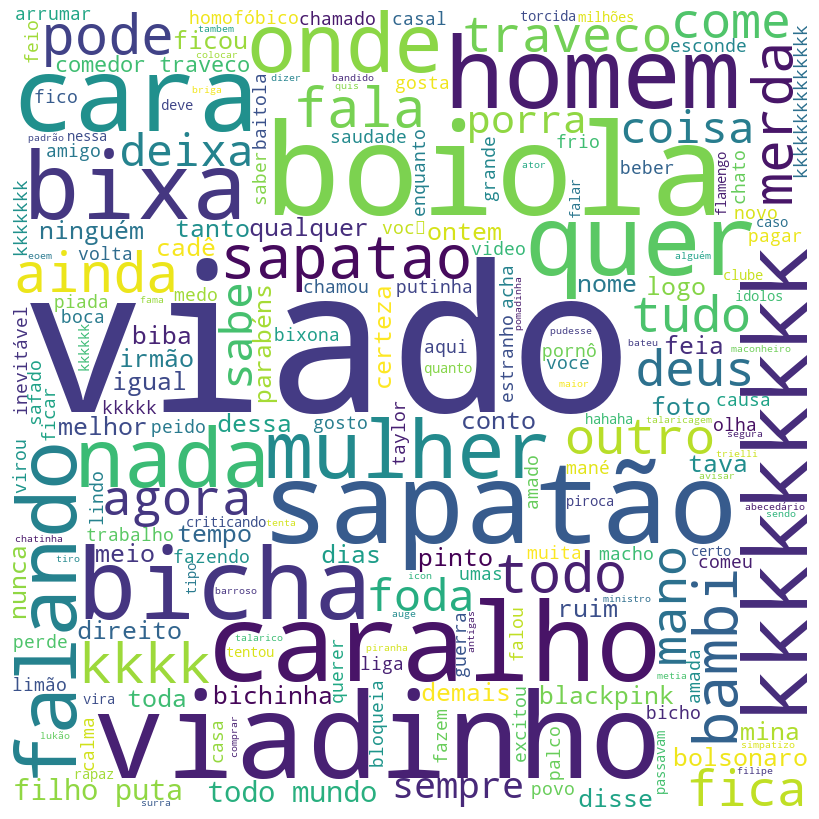

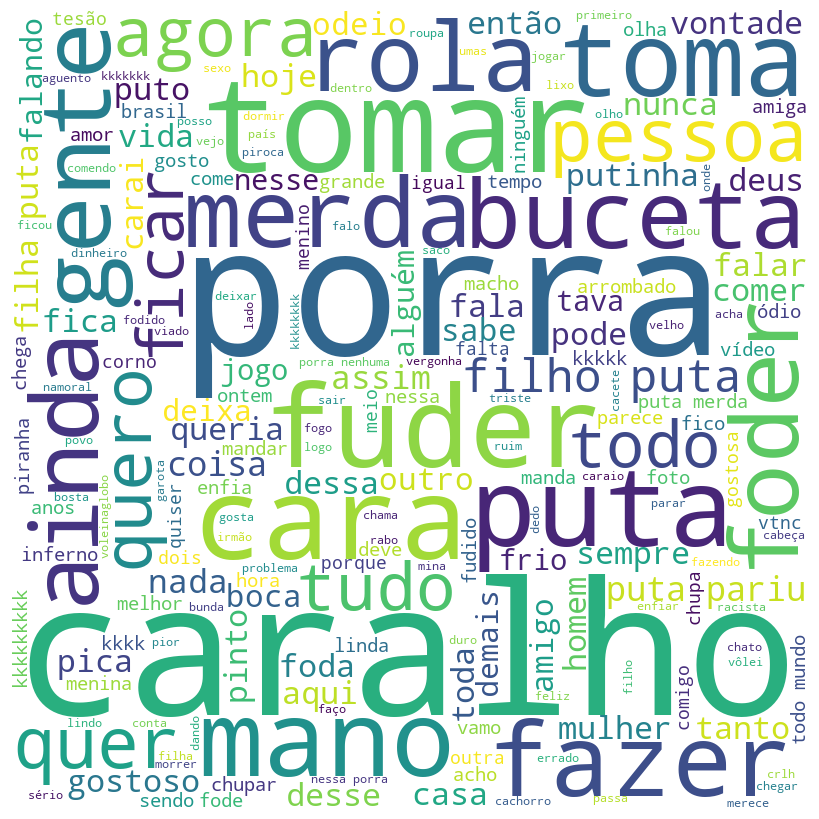

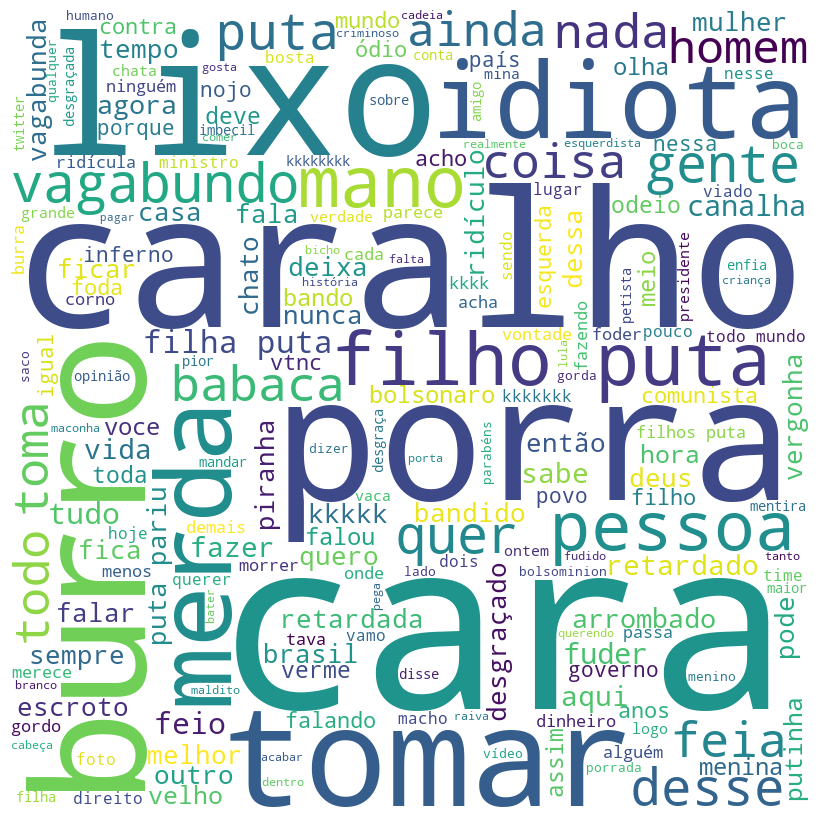

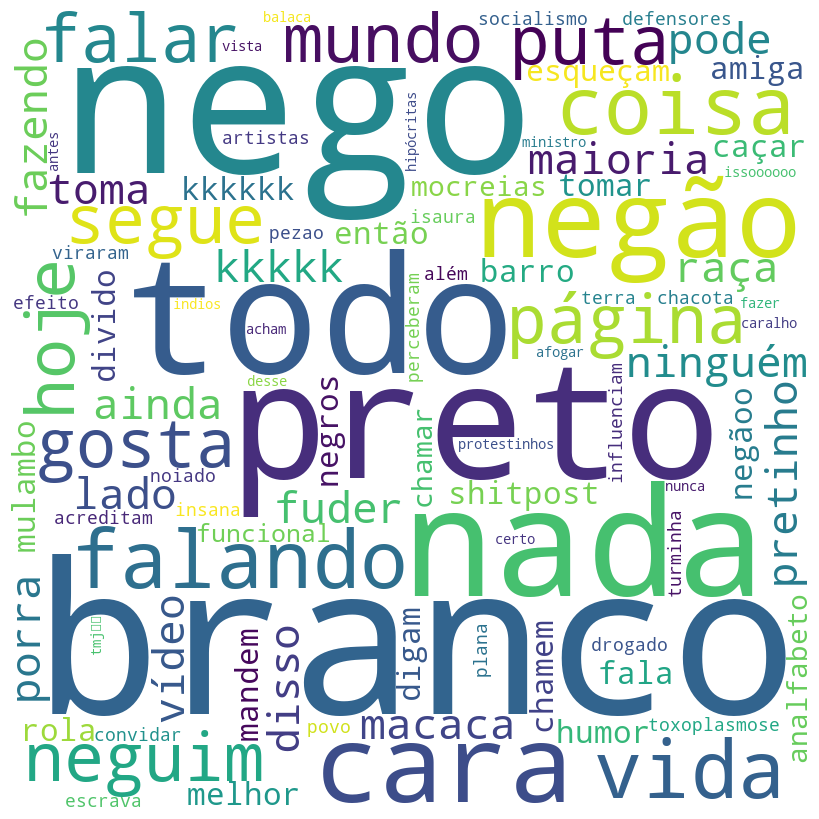

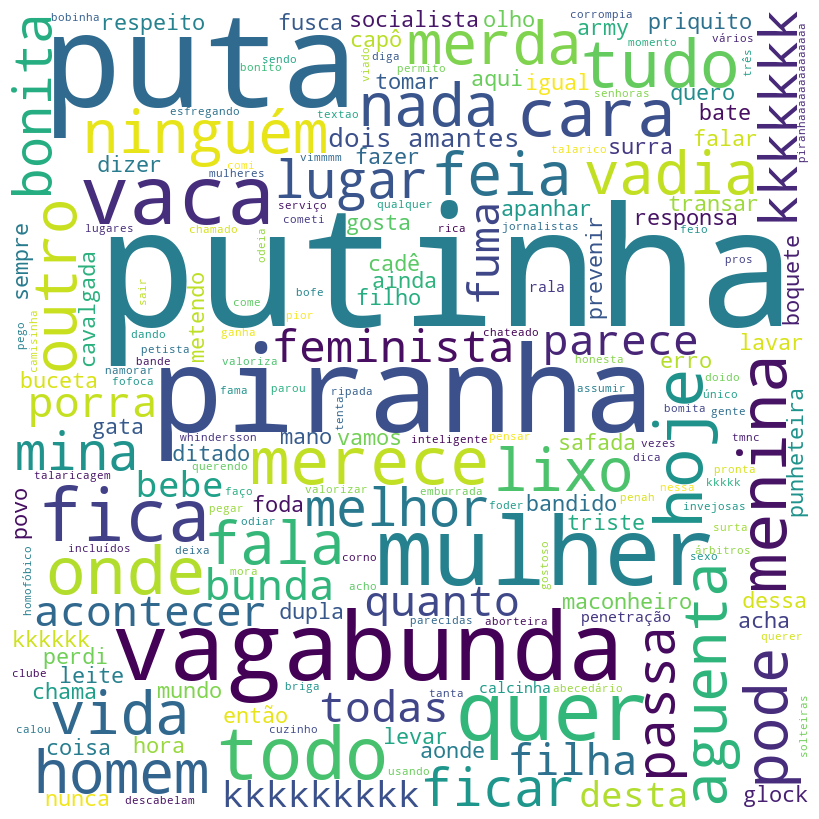

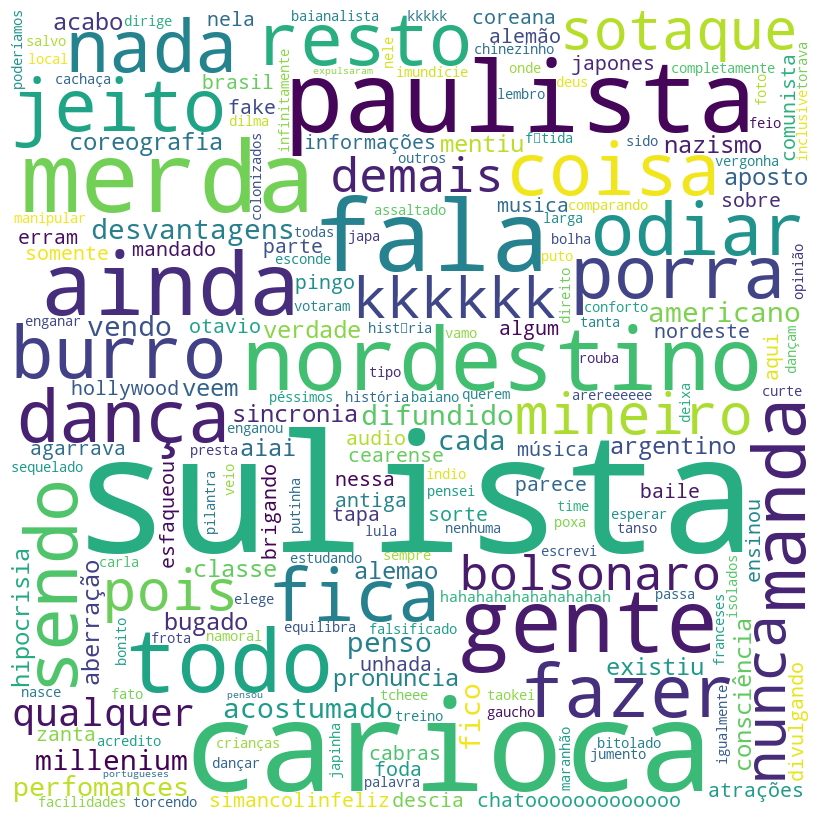

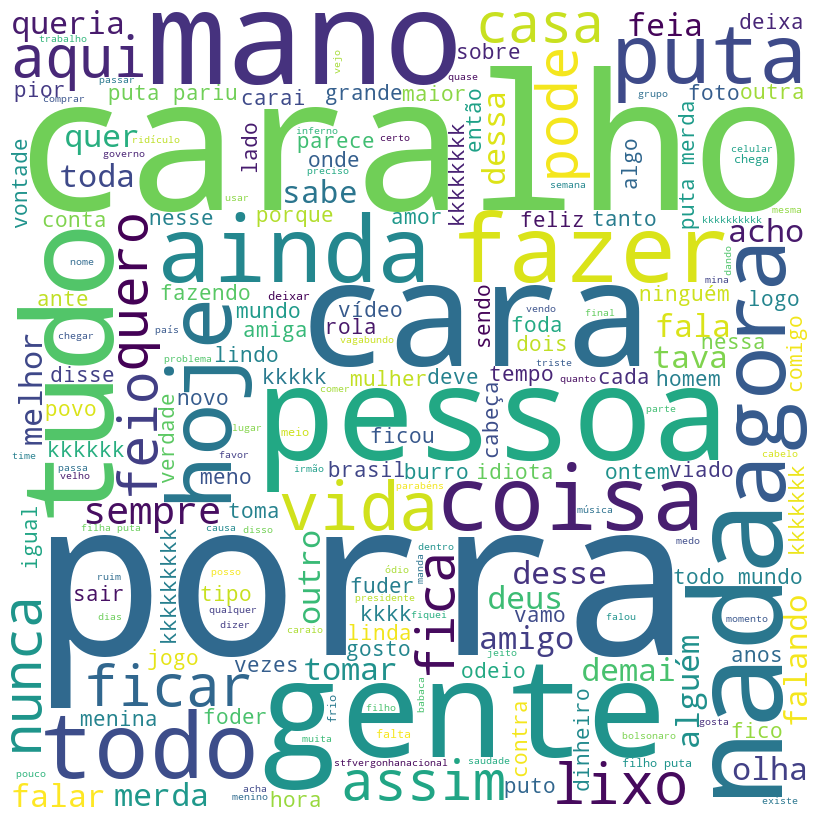

In [8]:
# Define o número de palavras mais frequentes a serem consideradas na análise
TOPN = 100

# Cria um DataFrame vazio para armazenar as frequências de palavras
freq = pd.DataFrame(columns=twitter_comments.columns)

# Renomeia a coluna "text" para "all" no DataFrame freq
freq.rename({"text": "all"}, axis=1, inplace=True)

# Itera sobre cada categoria de toxicidade no conjunto de dados
for CATEGORY in twitter_comments.columns[1:]:
    # Define uma lista de stopwords em português, incluindo algumas palavras adicionais
    stopwords = nltk.corpus.stopwords.words('portuguese')
    stopwords += ["https", "user"]

    # Tokeniza os comentários relevantes para a categoria atual
    tokenized = [nltk.word_tokenize(text.lower(), language="portuguese")
                 for text in twitter_comments[twitter_comments[CATEGORY] > 1]["text"]]

    # Inicializa uma lista auxiliar para armazenar os tokens relevantes
    aux = []
    for token in tokenized:
        # Adiciona palavras válidas (alfa, com mais de 3 caracteres e não stopwords) à lista auxiliar
        aux += [word for word in token if word.isalpha() and len(word)
                > 3 and word not in stopwords]

    # Calcula a frequência de cada palavra e armazena as TOPN palavras mais comuns na coluna correspondente do DataFrame freq
    freqdist = nltk.FreqDist(aux)
    freq[CATEGORY] = freqdist.most_common(TOPN)

    # Gera uma nuvem de palavras para a categoria atual
    wordcloud = WordCloud(width=800, height=800,
                          background_color='white',
                          stopwords=stopwords,
                          min_font_size=10).generate(" ".join(aux))

    # Plota a imagem da nuvem de palavras e a salva em um arquivo PNG
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig(f"./assets/images/bert/{CATEGORY}.png")

# Tokeniza todos os comentários do conjunto de dados
tokenized = [nltk.word_tokenize(text.lower(), language="portuguese")
             for text in twitter_comments["text"]]
aux = []
for token in tokenized:
    # Adiciona palavras válidas (alfa, com mais de 3 caracteres e não stopwords) à lista auxiliar
    aux += [word for word in token if word.isalpha() and len(word) >
            3 and word not in stopwords]

# Calcula a frequência de cada palavra em todos os comentários
freqdist = nltk.FreqDist(aux)
freq["all"] = freqdist.most_common(TOPN)

# Gera uma nuvem de palavras geral para todos os comentários
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10).generate(" ".join(aux))

# Plota a imagem da nuvem de palavras geral e a salva em um arquivo PNG
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig("./assets/images/bert/toxic.png")

### Relatórios

In [10]:
words = {}
for cat_1 in freq.columns[1:]:
    for cat_2 in freq.columns[1:]:
        if cat_1 != cat_2:
            dist = jaccard_distance({item[0] for item in freq[cat_1]}, {
                                    item[0] for item in freq[cat_2]})
            print(f"Distance between {cat_1.upper()} and {cat_2.upper()}: {dist:.2}")
    print()

Distance between HOMOPHOBIA and OBSCENE: 0.73
Distance between HOMOPHOBIA and INSULT: 0.78
Distance between HOMOPHOBIA and RACISM: 0.9
Distance between HOMOPHOBIA and MISOGYNY: 0.8
Distance between HOMOPHOBIA and XENOPHOBIA: 0.94

Distance between OBSCENE and HOMOPHOBIA: 0.73
Distance between OBSCENE and INSULT: 0.57
Distance between OBSCENE and RACISM: 0.84
Distance between OBSCENE and MISOGYNY: 0.77
Distance between OBSCENE and XENOPHOBIA: 0.9

Distance between INSULT and HOMOPHOBIA: 0.78
Distance between INSULT and OBSCENE: 0.57
Distance between INSULT and RACISM: 0.86
Distance between INSULT and MISOGYNY: 0.75
Distance between INSULT and XENOPHOBIA: 0.92

Distance between RACISM and HOMOPHOBIA: 0.9
Distance between RACISM and OBSCENE: 0.84
Distance between RACISM and INSULT: 0.86
Distance between RACISM and MISOGYNY: 0.87
Distance between RACISM and XENOPHOBIA: 0.95

Distance between MISOGYNY and HOMOPHOBIA: 0.8
Distance between MISOGYNY and OBSCENE: 0.77
Distance between MISOGYNY 

In [11]:
print(freq[:10])

               all      homophobia         obscene          insult  \
0    (porra, 1931)     (viado, 59)    (porra, 332)     (puta, 221)   
1  (caralho, 1681)    (boiola, 15)  (caralho, 317)  (caralho, 150)   
2     (puta, 1197)  (viadinho, 13)     (puta, 268)     (cara, 135)   
3      (cara, 816)   (sapatão, 12)    (tomar, 136)    (porra, 122)   
4     (gente, 772)   (caralho, 11)     (fuder, 98)     (lixo, 101)   
5      (mano, 700)      (cara, 10)      (cara, 94)     (filho, 92)   
6      (nada, 668)       (quer, 9)     (merda, 90)     (burro, 87)   
7      (tudo, 652)      (homem, 9)      (mano, 87)     (tomar, 86)   
8     (fazer, 622)       (todo, 9)      (toma, 85)     (merda, 78)   
9     (ainda, 540)      (bicha, 9)     (fazer, 77)    (idiota, 76)   

         racism         misogyny       xenophobia  
0     (nego, 6)    (putinha, 38)    (sulista, 12)  
1   (branco, 6)       (puta, 22)     (carioca, 7)  
2    (preto, 4)    (piranha, 19)        (fala, 4)  
3     (nada, 4)     (

In [12]:
# Criar uma nova coluna 'toxicity_level' que contém todos os tipos de toxicidade
twitter_comments['toxicity_level'] = twitter_comments.iloc[:, 1:].sum(axis=1)

C:\Users\rhogg\AppData\Local\Temp\ipykernel_11880\3076287211.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='toxicity_level', data=twitter_comments, palette='muted')


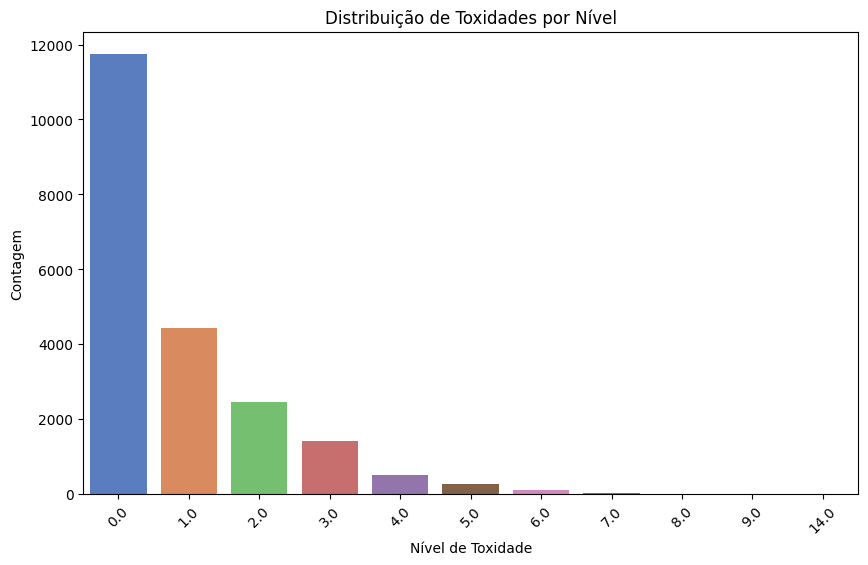

In [13]:
# Plotar o gráfico de contagem das toxidades com base no nível de toxidade
plt.figure(figsize=(10, 6))
sns.countplot(x='toxicity_level', data=twitter_comments, palette='muted')
plt.title('Distribuição de Toxidades por Nível')
plt.xlabel('Nível de Toxidade')
plt.ylabel('Contagem')
# Rotacionar os rótulos do eixo x para facilitar a leitura
plt.xticks(rotation=45)
plt.show()

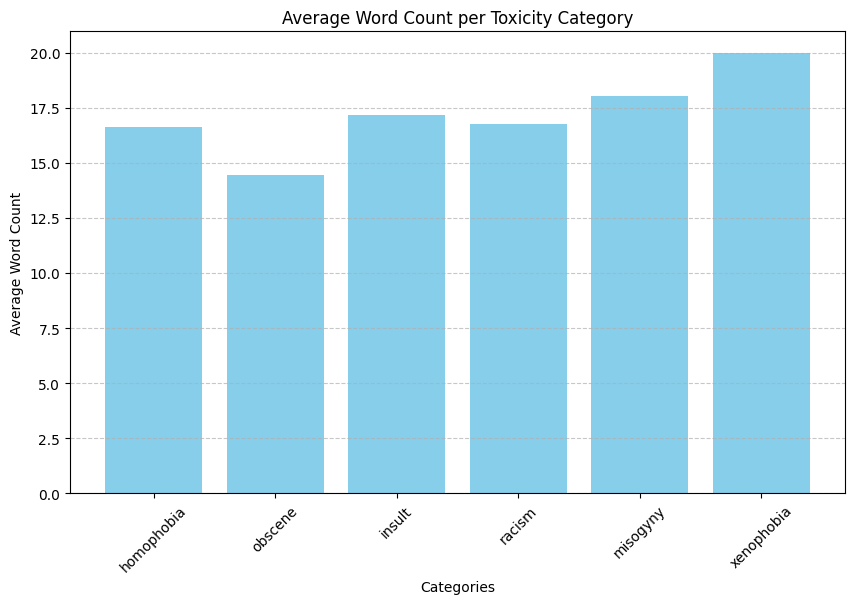

In [14]:
# Função para calcular o número de palavras
def word_count(text):
    return len(text.split())


categories = ['homophobia', 'obscene', 'insult',
              'racism', 'misogyny', 'xenophobia']

# Adicionando uma coluna de contagem de palavras ao DataFrame
twitter_comments['word_count'] = twitter_comments['text'].apply(word_count)

# Calcular a média de palavras por categoria para comentários tóxicos
average_words_per_category = {
    category: twitter_comments[twitter_comments[category] == 1]['word_count'].mean() for category in categories}

# Valores para o gráfico
categories = list(average_words_per_category.keys())
average_words = list(average_words_per_category.values())

plt.figure(figsize=(10, 6))
plt.bar(categories, average_words, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Average Word Count')
plt.title('Average Word Count per Toxicity Category')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [15]:
twitter_comments.head()

,text,homophobia,obscene,insult,racism,misogyny,xenophobia,toxicity_level,word_count
0,Meu nivel de amizade com isis é ela ter meu in...,0.0,0.0,2.0,0.0,0.0,0.0,2.0,33
1,"rt @user @user o cara adultera dados, que fora...",0.0,0.0,1.0,0.0,0.0,0.0,1.0,16
2,@user @user @user o cara só é simplesmente o m...,0.0,2.0,1.0,0.0,0.0,0.0,3.0,30
3,eu to chorando vei vsf e eu nem staneio izone ...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,13
4,Eleitor do Bolsonaro é tão ignorante q não per...,0.0,1.0,2.0,0.0,0.0,0.0,3.0,38


## Pré-processamento dos dados

### Normalização dos dados

In [16]:
# Verificando se o dataset possui algum valor faltando
twitter_comments.isnull().values.any()

False

In [17]:
categories = ['homophobia', 'obscene', 'insult',
              'racism', 'misogyny', 'xenophobia']


for category in categories:

    twitter_comments[category] = (twitter_comments[category] > 0).astype(int)

twitter_comments['toxicity_level'] = twitter_comments[categories].max(axis=1)

In [18]:
twitter_comments

,text,homophobia,obscene,insult,racism,misogyny,xenophobia,toxicity_level,word_count
0,Meu nivel de amizade com isis é ela ter meu in...,0,0,1,0,0,0,1,33
1,"rt @user @user o cara adultera dados, que fora...",0,0,1,0,0,0,1,16
2,@user @user @user o cara só é simplesmente o m...,0,1,1,0,0,0,1,30
3,eu to chorando vei vsf e eu nem staneio izone ...,0,1,0,0,0,0,1,13
4,Eleitor do Bolsonaro é tão ignorante q não per...,0,1,1,0,0,0,1,38
...,...,...,...,...,...,...,...,...,...
20995,@user faz favor vai carai,0,0,0,0,0,0,0,5
20996,só queria conhecer alguém que não conhece o he...,1,0,0,0,0,0,1,18
20997,"vcs militam na hora errada em cima de memes, p...",0,0,0,0,0,0,0,31
20998,@user porra any eu tava c dor de cabeca e fui ...,0,0,0,0,0,0,0,15


### Down Sample

In [19]:
toxic_comments = twitter_comments[twitter_comments['toxicity_level'] > 0]
normal_comments = twitter_comments[twitter_comments['toxicity_level'] == 0]

In [20]:
toxic_comments

,text,homophobia,obscene,insult,racism,misogyny,xenophobia,toxicity_level,word_count
0,Meu nivel de amizade com isis é ela ter meu in...,0,0,1,0,0,0,1,33
1,"rt @user @user o cara adultera dados, que fora...",0,0,1,0,0,0,1,16
2,@user @user @user o cara só é simplesmente o m...,0,1,1,0,0,0,1,30
3,eu to chorando vei vsf e eu nem staneio izone ...,0,1,0,0,0,0,1,13
4,Eleitor do Bolsonaro é tão ignorante q não per...,0,1,1,0,0,0,1,38
...,...,...,...,...,...,...,...,...,...
20983,"rt @user reclamam da minha boca suja, desculpa...",0,1,1,0,0,0,1,14
20988,@user caralho da espaço depois da vírgula aí b...,0,0,1,0,0,0,1,9
20990,mochila nas costas radinho na cintura bonezin ...,0,1,0,0,1,0,1,12
20991,rt @user meu pai é um puta irresponsável,0,0,1,0,0,0,1,8


In [21]:
normal_comments

,text,homophobia,obscene,insult,racism,misogyny,xenophobia,toxicity_level,word_count
6,tem um do jack com a msm música e agr não sei ...,0,0,0,0,0,0,0,17
12,"meu filho vem primeiro, ele é minha prioridade!",0,0,0,0,0,0,0,8
13,hoje deu vontade de abraçar minha mãe e chorar...,0,0,0,0,0,0,0,17
14,"Minha conta iria fazer 10 anos, em abril perde...",0,0,0,0,0,0,0,44
15,"@user não se ele tiver encomendado o ""serviço""",0,0,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...
20994,que homem! @user,0,0,0,0,0,0,0,3
20995,@user faz favor vai carai,0,0,0,0,0,0,0,5
20997,"vcs militam na hora errada em cima de memes, p...",0,0,0,0,0,0,0,31
20998,@user porra any eu tava c dor de cabeca e fui ...,0,0,0,0,0,0,0,15


In [22]:
downsampled_data = resample(
    normal_comments, replace=False, n_samples=len(toxic_comments), random_state=34)

balanced_data = pd.concat([downsampled_data, toxic_comments])

balanced_data

,text,homophobia,obscene,insult,racism,misogyny,xenophobia,toxicity_level,word_count
510,old que blinkonce nao existe https://t.co/nxtw...,0,0,0,0,0,0,0,6
15494,eu tô preocupada com meus amigos não sei oq fo...,0,0,0,0,0,0,0,39
16817,sou um lixo kk,0,0,0,0,0,0,0,4
14722,eu vendo a thread das sapatão https://t.co/o05...,0,0,0,0,0,0,0,7
360,Ninguém está de bem com a vida. Todos nós temo...,0,0,0,0,0,0,0,39
...,...,...,...,...,...,...,...,...,...
20983,"rt @user reclamam da minha boca suja, desculpa...",0,1,1,0,0,0,1,14
20988,@user caralho da espaço depois da vírgula aí b...,0,0,1,0,0,0,1,9
20990,mochila nas costas radinho na cintura bonezin ...,0,1,0,0,1,0,1,12
20991,rt @user meu pai é um puta irresponsável,0,0,1,0,0,0,1,8


### Limpeza de string

In [23]:
TAG_RE = re.compile(r'<[^>]+>')

# Remover tags HTML: trocando o valor entre <> por espaço em branco


def remove_tags(text):
    return TAG_RE.sub('', text)

In [24]:
def remove_links(text):
    # Expressão regular para encontrar links
    link_pattern = r'https?:\/\/\S+'
    # Substituir os links por uma string vazia
    text_without_links = re.sub(link_pattern, '', text)
    return text_without_links

In [25]:
def remove_accent(text):
    # Remover acentos das letras
    text_without_accent = unidecode(text)
    return text_without_accent

In [26]:
# Teste da função em um exemplo
text_with_accents = "ÀàÁáÂâÃãÄäÇçÈèÉéÊêËëÌìÍíÎîÏïÑñÒòÓóÔôÕõÖöÙùÚúÛûÜüÝýŸÿ"
text_without_accent = remove_accent(text_with_accents)
print("Texto original:", text_with_accents)
print("Texto sem acentos:", text_without_accent)

Texto original: ÀàÁáÂâÃãÄäÇçÈèÉéÊêËëÌìÍíÎîÏïÑñÒòÓóÔôÕõÖöÙùÚúÛûÜüÝýŸÿ
Texto sem acentos: AaAaAaAaAaCcEeEeEeEeIiIiIiIiNnOoOoOoOoOoUuUuUuUuYyYy


In [27]:
def preprocess_text(sen):
    sentence = sen.lower()

    # Remove os links
    sentence = remove_links(sentence)

    # Remove tags html
    sentence = remove_tags(sentence)

    # Remove acentos das letras
    sentence = remove_accent(sentence)

    # Remover acentos isolados
    sentence = re.sub(
        r'(?<![a-zA-Z])([áéíóúýçõãñèyùìòàêûîôâäëïöüÿ])(?![a-zA-Z])', '', sentence)

    # Alternar entre essa e a de baixo para comparar se afeta algo
    # # Remove pontuações e números
    # sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Remove pontuações (mantém os números)
    sentence = re.sub('[^a-zA-Z0-9]', ' ', sentence)

    # Remove apóstrofos
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Remove multiplos espaços
    sentence = re.sub(r'\s+', ' ', sentence)

    # Remove Stopwords
    pattern = re.compile(
    r'\b(' + r'|'.join(nltk.corpus.stopwords.words('portuguese')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [28]:
# Executando limpeza
balanced_data['text'] = balanced_data['text'].apply(preprocess_text)

In [29]:
balanced_data['text']

510                              old blinkonce nao existe 
15494    to preocupada amigos nao sei oq tomaram ontem ...
16817                                              lixo kk
14722                                vendo thread sapatao 
360      ninguem bem vida todos jardins secretos planta...
                               ...                        
20983    rt user reclamam boca suja desculpa ai vai tom...
20988                 user caralho espaco virgula ai burro
20990    mochila costas radinho cintura bonezin pra tra...
20991                       rt user pai puta irresponsavel
20996    so queria conhecer alguem nao conhece hetero t...
Name: text, Length: 18510, dtype: object

## Separação dos dados

In [30]:
X = balanced_data['text'].values
y = balanced_data['toxicity_level'].values

In [31]:
X

array(['old blinkonce nao existe ',
       'to preocupada amigos nao sei oq tomaram ontem tao mal pra carai aqui serase devo levar upa devo deixar boinha pq so ressaca vai passar ',
       'lixo kk', ...,
       'mochila costas radinho cintura bonezin pra tras so cacando puta',
       'rt user pai puta irresponsavel',
       'so queria conhecer alguem nao conhece hetero taubate meninas ta foda pqp'],
      dtype=object)

In [32]:
y

array([0, 0, 0, ..., 1, 1, 1])

## Tokenização e preparação dos dados

In [33]:
FullTokenizer = bert.tokenization.bert_tokenization.FullTokenizer


bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1', trainable=False)


vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()


do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()


tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [34]:
# Definindo uma função para codificar um comentário usando o tokenizador BERT
def encode_sentence(sent):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent))

In [35]:
data_inputs = [encode_sentence(sentence) for sentence in X]
data_inputs

[[2214, 12373, 2239, 3401, 6583, 2080, 4839, 2063],
 [2000,
  3653,
  10085,
  6279,
  8447,
  26445,
  12333,
  6583,
  2080,
  7367,
  2072,
  1051,
  4160,
  3419,
  5400,
  2213,
  2006,
  18532,
  20216,
  15451,
  10975,
  2050,
  14418,
  2072,
  1037,
  15549,
  26358,
  3366,
  16475,
  2080,
  23310,
  2906,
  2039,
  2050,
  16475,
  2080,
  14866,
  18684,
  2099,
  8945,
  2378,
  3270,
  1052,
  4160,
  2061,
  24501,
  3736,
  3540,
  12436,
  2072,
  3413,
  2906],
 [5622, 2595, 2080, 1047, 2243],
 [2310, 15482, 11689, 20066, 6790, 2080],
 [9152,
  3070,
  5657,
  2213,
  2022,
  2213,
  19830,
  28681,
  2891,
  15723,
  8718,
  2015,
  3595,
  2891,
  3269,
  22684,
  2229,
  1999,
  19699,
  21823,
  27709,
  2015,
  7942,
  6494,
  15530,
  9765,
  9365,
  10768,
  10415,
  27893,
  2063,
  18499,
  4226,
  10768,
  10415,
  27893,
  2063,
  7812,
  4111,
  2715,
  2080,
  1999,
  15338,
  7140,
  10514,
  6442,
  2906,
  21877,
  6499,
  17678,
  4360,
  4839,
  27

In [36]:
data_withn_len = [[sent, y[i], len(sent)]
                  for i, sent in enumerate(data_inputs)]

In [37]:
data_withn_len[0:2]

[[[2214, 12373, 2239, 3401, 6583, 2080, 4839, 2063], 0, 8],
 [[2000,
   3653,
   10085,
   6279,
   8447,
   26445,
   12333,
   6583,
   2080,
   7367,
   2072,
   1051,
   4160,
   3419,
   5400,
   2213,
   2006,
   18532,
   20216,
   15451,
   10975,
   2050,
   14418,
   2072,
   1037,
   15549,
   26358,
   3366,
   16475,
   2080,
   23310,
   2906,
   2039,
   2050,
   16475,
   2080,
   14866,
   18684,
   2099,
   8945,
   2378,
   3270,
   1052,
   4160,
   2061,
   24501,
   3736,
   3540,
   12436,
   2072,
   3413,
   2906],
  0,
  52]]

In [38]:
random.shuffle(data_withn_len)  # misturar os dados
data_withn_len.sort(key=lambda x: x[2])  # x[2] tamanho da frase
sorted_all = [(sent_lab[0], sent_lab[1])
              for sent_lab in data_withn_len if sent_lab[2] > 0]

In [39]:
all_dataset = tf.data.Dataset.from_generator(
    lambda: sorted_all, output_types=(tf.int32, tf.int32))

In [40]:
next(iter(all_dataset))

(<tf.Tensor: shape=(1,), dtype=int32, numpy=array([5310])>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>)

In [41]:
BATCH_SIZE = 24
all_batched = all_dataset.padded_batch(BATCH_SIZE, padded_shapes=(
    (None,), ()))  # Pegar exatamente o que está na base de dados

In [42]:
next(iter(all_batched))

(<tf.Tensor: shape=(24, 2), dtype=int32, numpy=
 array([[ 5310,     0],
        [22939,     0],
        [14124,     0],
        [12731,     0],
        [12731,     0],
        [ 5310, 12731],
        [ 2004,  3597],
        [26445,  3995],
        [27263,  2050],
        [ 6904, 24458],
        [14124, 21848],
        [24665, 19629],
        [18691,  2080],
        [24664,  2050],
        [ 2852, 18170],
        [ 6846,  2015],
        [ 6904,  3597],
        [12170, 12519],
        [19387,  5310],
        [ 1042, 13390],
        [ 5310, 12731],
        [ 2365,  6806],
        [ 2572,  2290],
        [13075, 10735]])>,
 <tf.Tensor: shape=(24,), dtype=int32, numpy=
 array([0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0])>)

In [43]:
NB_BATCHES = len(sorted_all) // BATCH_SIZE
NB_BATCHES

771

In [44]:
NB_BATCHES_TEST = NB_BATCHES // 10
NB_BATCHES_TEST

77

In [45]:
all_batched.shuffle(NB_BATCHES)

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [46]:
# Para visualizar o dataset
print("Exemplo do dataset:")
for example_input, example_output in all_batched:
    print("Input Shape:", example_input.shape)
    print("Output Shape:", example_output.shape)
    print("Input Values:", example_input.numpy())
    print("Output Values:", example_output.numpy())
    break  # apenas para imprimir o primeiro exemplo

Exemplo do dataset:
Input Shape: (24, 2)
Output Shape: (24,)
Input Values: [[ 5310     0]
 [22939     0]
 [14124     0]
 [12731     0]
 [12731     0]
 [ 5310 12731]
 [ 2004  3597]
 [26445  3995]
 [27263  2050]
 [ 6904 24458]
 [14124 21848]
 [24665 19629]
 [18691  2080]
 [24664  2050]
 [ 2852 18170]
 [ 6846  2015]
 [ 6904  3597]
 [12170 12519]
 [19387  5310]
 [ 1042 13390]
 [ 5310 12731]
 [ 2365  6806]
 [ 2572  2290]
 [13075 10735]]
Output Values: [0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0]


In [47]:
test_dataset = all_batched.take(NB_BATCHES_TEST)
# pegar os registros tirando o que o teste já pegou
train_dataset = all_batched.skip(NB_BATCHES_TEST)

In [48]:
# Para visualizar o dataset de treinamento (train_dataset)
print("Exemplo do dataset de treinamento:")
for example_input, example_output in train_dataset:
    print("Input Shape:", example_input.shape)
    print("Output Shape:", example_output.shape)
    print("Input Values:", example_input.numpy())
    print("Output Values:", example_output.numpy())
    break  # apenas para imprimir o primeiro exemplo

Exemplo do dataset de treinamento:
Input Shape: (24, 7)
Output Shape: (24,)
Input Values: [[29536  2226 14684  2696  8154 13852  2063]
 [ 5310  5310 14418 28061  1042 11253  2080]
 [ 5310  9530  2696  1047 19658 19658 19658]
 [ 5310  2012  8180  2316 13820 11463 16368]
 [ 5310 11968 26005 15482 19817 10696  3597]
 [ 5310  5310  2061  1037 15549  1062  7856]
 [ 5310  5469  2158  2080  9436  2594 18845]
 [ 5310 24576  4012 19496  9153  2181 23921]
 [ 5310  9543 14949  8652  4487  7512 15781]
 [ 5310  2522 14268 24664  2050  8991  2618]
 [ 6643  2072  8292  2226 22135 14995 15533]
 [ 5310 10861  3217 18315 12436 11865  4063]
 [ 5310 11937  8945  2213  8945 20282  2050]
 [11320  6843  5684  9956 25989 11503  2050]
 [ 2061 24126 11721  2696  1052  4160  2361]
 [14418 28061  2572  2080 24964 12203  2080]
 [ 2404  2050 11968 17922  8183  3654  2080]
 [ 2522 27893  2080  6583  2080 14262  3695]
 [ 2158  2080  6583  2080 23204 15544  2243]
 [ 5310 26089  6904  8017 12731 22720 20216]
 [19387  5

In [49]:
# Para visualizar o dataset de teste (test_dataset)
print("Exemplo do dataset de teste:")
for example_input, example_output in test_dataset:
    print("Input Shape:", example_input.shape)
    print("Output Shape:", example_output.shape)
    print("Input Values:", example_input.numpy())
    print("Output Values:", example_output.numpy())
    break  # apenas para imprimir o primeiro exemplo

Exemplo do dataset de teste:
Input Shape: (24, 2)
Output Shape: (24,)
Input Values: [[ 5310     0]
 [22939     0]
 [14124     0]
 [12731     0]
 [12731     0]
 [ 5310 12731]
 [ 2004  3597]
 [26445  3995]
 [27263  2050]
 [ 6904 24458]
 [14124 21848]
 [24665 19629]
 [18691  2080]
 [24664  2050]
 [ 2852 18170]
 [ 6846  2015]
 [ 6904  3597]
 [12170 12519]
 [19387  5310]
 [ 1042 13390]
 [ 5310 12731]
 [ 2365  6806]
 [ 2572  2290]
 [13075 10735]]
Output Values: [0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0]


## Rede BERT

### Criação do modelo

In [50]:
class DCNN(tf.keras.Model):
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name='dcnn'):
        super(DCNN, self).__init__(name=name)

        self.embedding = layers.Embedding(vocab_size, emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding='valid',
                                    activation='relu')
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding='valid',
                                     activation='relu')
        self.fourngram = layers.Conv1D(filters=nb_filters,
                                       kernel_size=4,
                                       padding='valid',
                                       activation='relu')

        self.pool = layers.GlobalMaxPool1D()
        self.dense_1 = layers.Dense(units=FFN_units, activation='relu')
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1, activation='sigmoid')
        else:
            self.last_dense = layers.Dense(
                units=nb_classes, activation='softmax')

    def call(self, inputs, training):
        # print("Input shape:", inputs.shape)
        x = self.embedding(inputs)
        # print("Embedding output shape:", x.shape)
        x_1 = self.bigram(x)
        # print("Bigram output shape:", x_1.shape)
        x_1 = self.pool(x_1)
        # print("Bigram pooled output shape:", x_1.shape)
        x_2 = self.trigram(x)
        # print("Trigram output shape:", x_2.shape)
        x_2 = self.pool(x_2)
        # print("Trigram pooled output shape:", x_2.shape)
        x_3 = self.fourngram(x)
        # print("Four-gram output shape:", x_3.shape)
        x_3 = self.pool(x_3)
        # print("Four-gram pooled output shape:", x_3.shape)

        merged = tf.concat([x_1, x_2, x_3], axis=-1)
        # print("Merged output shape:", merged.shape)
        merged = self.dense_1(merged)
        # print("Dense output shape:", merged.shape)
        merged = self.dropout(merged, training=training)
        output = self.last_dense(merged)
        # print("Output shape:", output.shape)

        return output

In [51]:
VOCAB_SIZE = len(tokenizer.vocab)
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2
DROUPOUT_RATE = 0.2
NB_EPOCHS = 40

In [52]:
Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROUPOUT_RATE)

In [53]:
def recall_m(y_true, y_pred):
    y_true = tf.keras.backend.cast(y_true, 'float32')
    y_pred = tf.keras.backend.cast(y_pred, 'float32')
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(
        tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(
        tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall


def precision_m(y_true, y_pred):
    y_true = tf.cast(y_true, 'float32')
    y_pred = tf.keras.backend.cast(y_pred, 'float32')
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(
        tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(
        tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / \
        (predicted_positives + tf.keras.backend.epsilon())
    return precision


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))

### Compilação

In [54]:
if NB_CLASSES == 2:
    Dcnn.compile(loss='binary_crossentropy', optimizer='adam',
                 metrics=['accuracy', f1_m, precision_m, recall_m])
else:
    Dcnn.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam', metrics=['sparse_categorical_accuracy'])

### Treinamento

In [55]:
history = Dcnn.fit(train_dataset, epochs=NB_EPOCHS)

Epoch 1/40
695/695 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.6849 - f1_m: 12.3542 - loss: 0.5840 - precision_m: 12.0741 - recall_m: 13.4558
Epoch 2/40


c:\Users\rhogg\anaconda3\envs\toxicity-classifier-bert\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


695/695 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.7856 - f1_m: 12.5821 - loss: 0.4417 - precision_m: 12.1973 - recall_m: 13.2858
Epoch 3/40
695/695 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.8561 - f1_m: 12.4472 - loss: 0.3238 - precision_m: 12.1973 - recall_m: 12.8868
Epoch 4/40
695/695 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9082 - f1_m: 12.2773 - loss: 0.2155 - precision_m: 12.1973 - recall_m: 12.4922
Epoch 5/40
695/695 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.9234 - f1_m: 12.2777 - loss: 0.1827 - precision_m: 12.1973 - recall_m: 12.5134
Epoch 6/40
695/695 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.9433 - f1_m: 12.2770 - loss: 0.1412 - precision_m: 12.1973 - recall_m: 12.4701
Epoch 7/40
695/695 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.9621 - f1_m: 12.2394 - loss: 0.1021 - precision_m: 12.1973 - recall_m: 12.3466
Epoch 8/40
695/695 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.9718 - f1_m: 12.1891 - loss: 0.0749 - precision_m: 12.1973 - 

## Avaliação do modelo

### Avaliação Básica

In [63]:
history.history.keys()

dict_keys(['accuracy', 'f1_m', 'loss', 'precision_m', 'recall_m'])

In [65]:
train_dataset

<_SkipDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [66]:
test_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Curva de aprendizado

Text(0.5, 1.0, 'Loss progress')

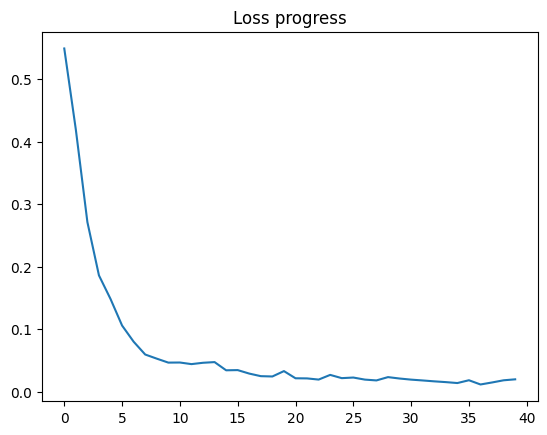

In [67]:
plt.plot(history.history['loss'])
plt.title('Loss progress')

Text(0.5, 1.0, 'accuracy progress')

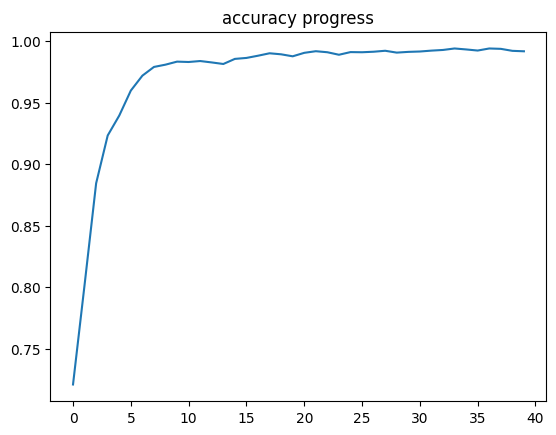

In [68]:
plt.plot(history.history['accuracy'])
plt.title('accuracy progress')

### Predição

In [96]:
# Digite um comentário como entrada
comment_text = "esse criolo veio até na minha loja e roubou a porra de um desodorante do krl, vtnc"
comment2_text = "Hoje foi um dia bom, apenas trabalhei, assisti aula de redes neurais e joguei valorant"

# Tokenizar o comentário
encoded_comment = encode_sentence(comment_text)
encoded_comment2 = encode_sentence(comment2_text)

# Realizar a predição com o modelo
prediction = Dcnn.predict(tf.convert_to_tensor([encoded_comment]))
prediction2 = Dcnn.predict(tf.convert_to_tensor([encoded_comment2]))

# Avaliar a predição
if prediction > 0.5:
    print("O comentário é tóxico.")
else:
    print("O comentário é normal.")

if prediction2 > 0.5:
    print("O comentário é tóxico.")
else:
    print("O comentário é normal.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
O comentário é tóxico.
O comentário é normal.


### Métricas para o BERT

In [97]:
loss, accuracy, f1_score, precision, recall = Dcnn.evaluate(
    train_dataset, verbose=1)
print("Validacao")
print("loss: %.4f" % (loss))
print("acc: %.4f" % (accuracy))
print("f1_score: %.4f" % (f1_score))
print("precision: %.4f" % (precision))
print("recall: %.4f" % (recall))

695/695 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9832 - f1_m: 12.3637 - loss: 0.0452 - precision_m: 12.1973 - recall_m: 12.5528
Validacao
loss: 0.0277
acc: 0.9888
f1_score: 12.1005
precision: 11.9885
recall: 12.2270


c:\Users\rhogg\anaconda3\envs\toxicity-classifier-bert\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [ ]:
# loss, accuracy, f1_score, precision, recall = Dcnn.evaluate(
#     test_dataset, verbose=1)
# print("Validacao")
# print("loss: %.4f" % (loss))
# print("acc: %.4f" % (accuracy))
# print("f1_score: %.4f" % (f1_score))
# print("precision: %.4f" % (precision))
# print("recall: %.4f" % (recall))

## Deploy

In [109]:
# Salvando o modelo em formato h5
Dcnn.save(f"models/bert_model_acc_{round(accuracy*100, 2)}.h5", save_format='h5')